## Visualizing what convnets learn
It’s often said that deep-learning models are “black boxes”: learning representations that are difficult to extract and present in a human-readable form. Although this is partially true for certain types of deep-learning models, it’s definitely not true for convnets.

The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts. Since 2013, a wide array of techniques have been developed for visualizing and interpreting these representations. We won’t survey all of them, but we’ll cover three of the most accessible and useful ones:
* Visualizing intermediate convnet outputs (intermediate activations)—Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.
* Visualizing convnets filters—Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.
* Visualizing heatmaps of class activation in an image—Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images.

## Visualizing intermediate activations

Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function)

Let’s start by loading the model that you saved in the previous section

In [1]:
from keras.models import load_model

Using TensorFlow backend.


In [2]:
model = load_model('cats_and_dogs_small_2.h5')

In [3]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

Next, you’ll get an input image—a picture of a cat, not part of the images the network was trained on.

### Preprocessing a single image

In [15]:
img_path = 'D:/cats_and_dogs_data/cats_and_dogs_small/test/cats/cat.1502.jpg'

In [16]:
from keras.preprocessing import image
import numpy as np

In [17]:
#Remember that the model was trained on inputs that were preprocessed this way.
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

### Displaying the test picture

In [18]:
import matplotlib.pyplot as plt

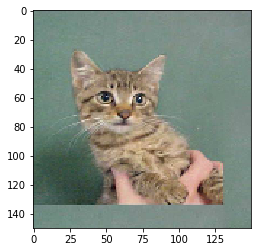

In [19]:
plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps you want to look at, you’ll create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. 

A model is instantiated using two arguments: an input tensor (or list of input tensors) and an output tensor (or list of output tensors)

### Instantiating a model from an input tensor and a list of output tensors

In [20]:
from keras import models

In [21]:
# Extracts the outputs of the top eight layers
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 

### Running the model in predict mode

In [22]:
activations = activation_model.predict(img_tensor)
# Returns a list of five Numpy arrays: one array per layer activation

For instance, this is the activation of the first convolution layer for the cat image input:

In [24]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


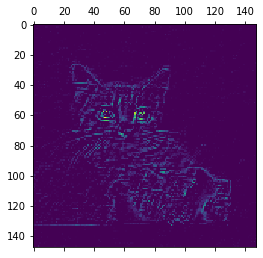

In [32]:
plt.matshow(first_layer_activation[0, :, :, 6], cmap='viridis')

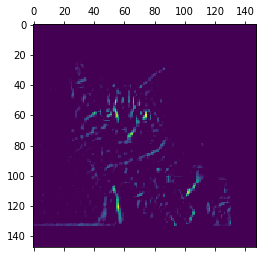

In [43]:
plt.matshow(first_layer_activation[0, :, :, 11], cmap='viridis')

At this point, let’s plot a complete visualization of all the activations in the network

### Visualizing every channel in every intermediate activation

In [46]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
images_per_row = 16

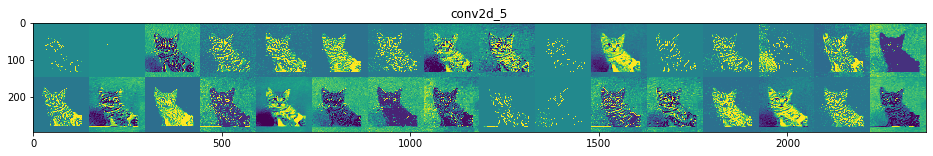

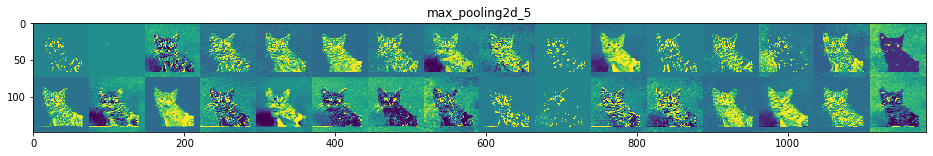

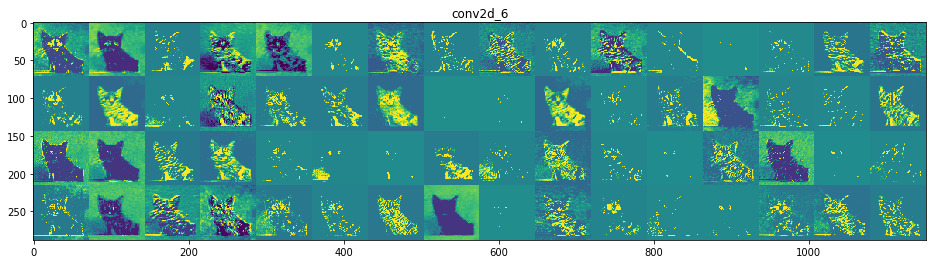

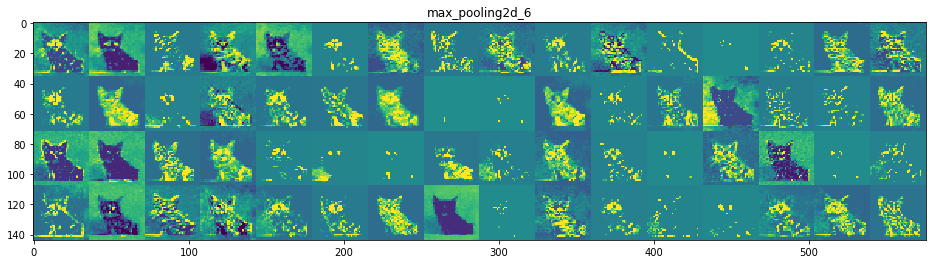

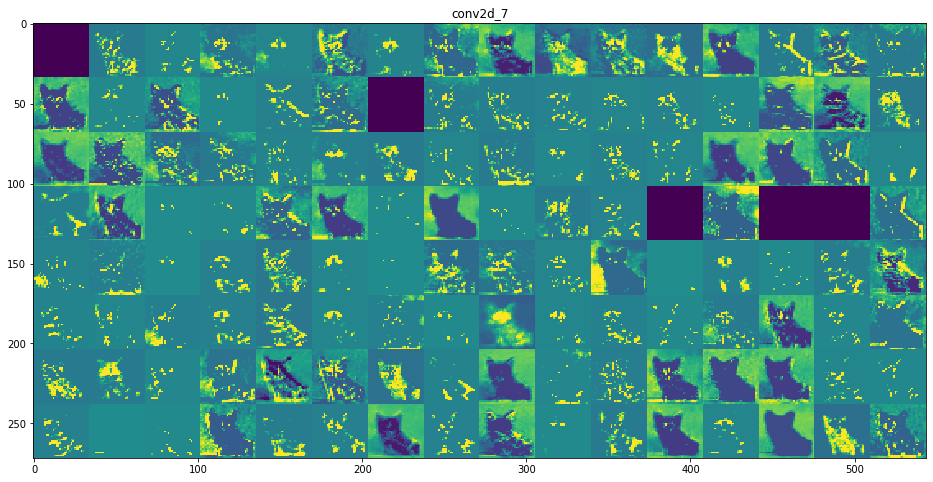

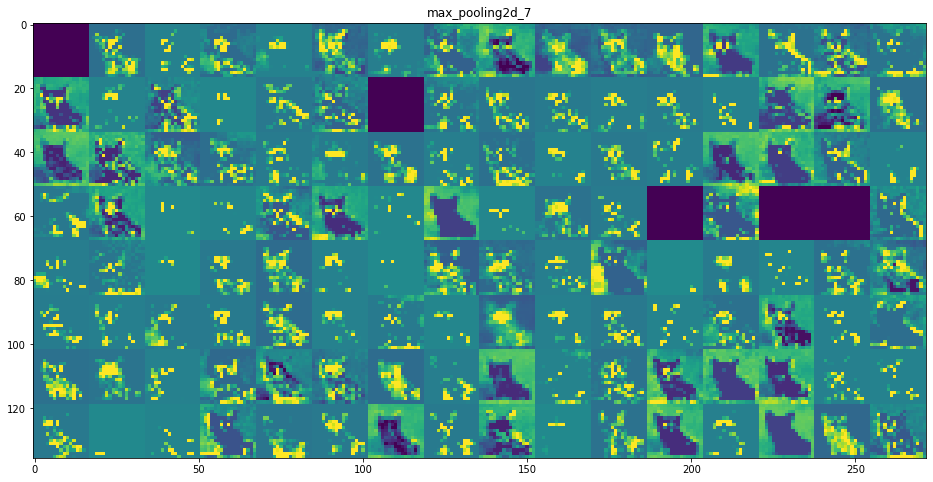

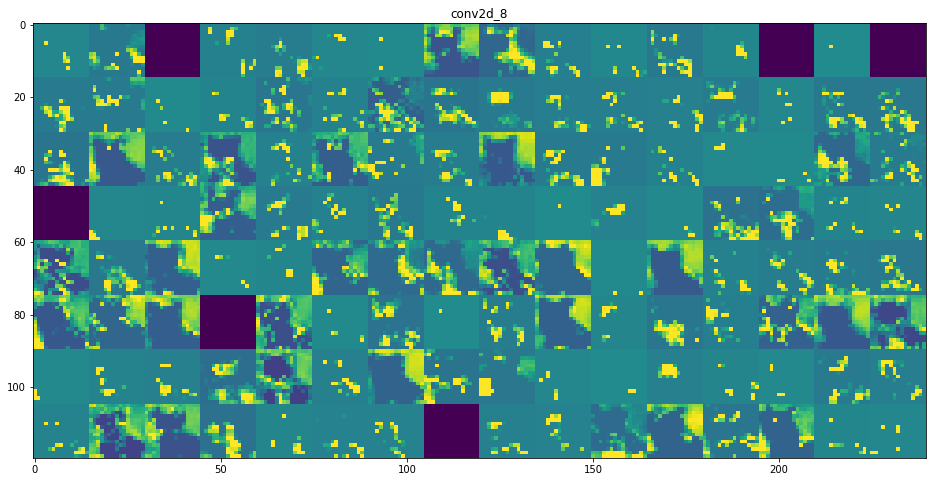

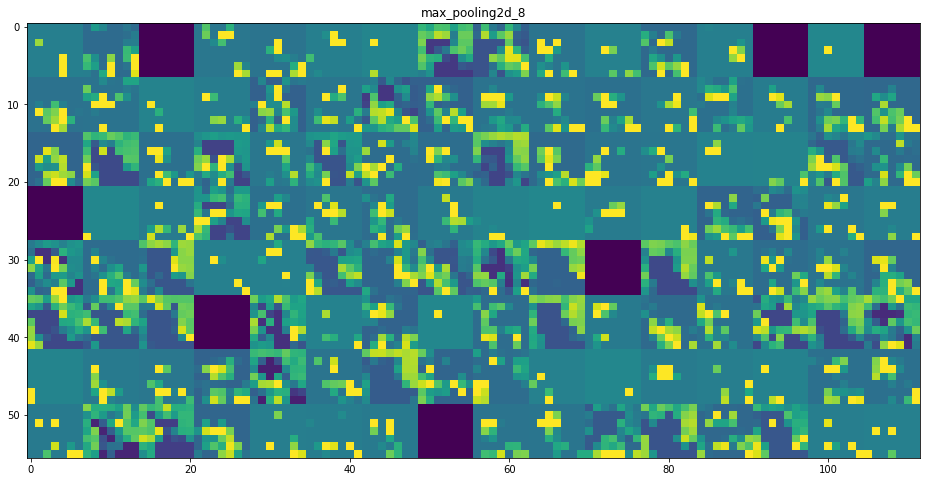

In [47]:
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
            row * size : (row + 1) * size] = channel_image
            scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

There are a few things to note here:
* The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
* As you go higher, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye.” Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
* The sparsity of the activations increases with the depth of the layer: in the first layer, all filters are activated by the input image; but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in the input image.

## Visualizing convnet filters

### Defining the loss tensor for filter visualization

In [49]:
from keras.applications import VGG16
from keras import backend as K

In [50]:
model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

### Obtaining the gradient of the loss with regard to the input

In [51]:
grads = K.gradients(loss, model.input)[0]
#The call to gradients returns a list of tensors (of size 1 in this case).
#Hence, you keep only the first element— which is a tensor.

Gradient-normalization trick

In [52]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
#Add 1e–5 before dividing to avoid accidentally dividing by 0.

### Fetching Numpy output values given Numpy input values

In [53]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

At this point, you can define a Python loop to do stochastic gradient descent.

### Loss maximization via stochastic gradient descent

In [54]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128. #Starts from a gray image with some noise

In [55]:
step = 1. #Magnitude of each gradient update
for i in range(40):
    loss_value, grads_value = iterate([input_img_data]) #Computes the loss value and gradient value
    input_img_data += grads_value * step # Adjusts the input image in the direction that maximizes the loss

### Utility function to convert a tensor into a valid image

In [56]:
def deprocess_image(x):
    # Normalizes the tensor:
    # centers on 0, ensures that std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1) # Clips to [0, 1]
    # Converts to an RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Function to generate filter visualizations

In [64]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

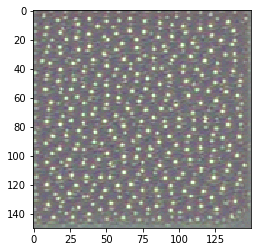

In [78]:
plt.imshow(generate_pattern('block3_conv1', 0))

It seems that filter 0 in layer block3_conv1 is responsive to a polka-dot pattern. Now the fun part: you can start visualizing every filter in every layer.

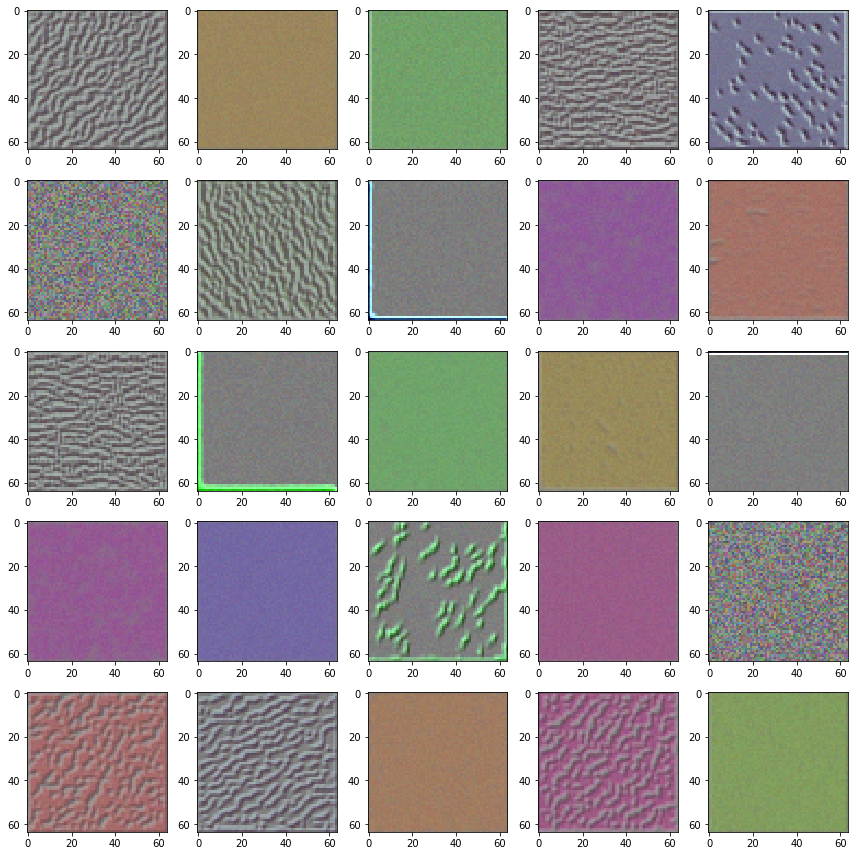

In [80]:
columns = 5
rows = 5

fig=plt.figure(figsize=(12, 12))

ax = []

for i in range(columns*rows):  
    
      
    ax.append(fig.add_subplot(rows, columns, i+1))
    plt.imshow(generate_pattern(layer_name, i, size=64))
 
    
plt.tight_layout()
plt.show()

## Visualizing heatmaps of class activation

Loading the VGG16 network with pretrained weights

from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

Consider the image of two African elephants shown in the next figure (under a Creative Commons license), possibly a mother and her calf, strolling on the savanna. Let’s convert this image into something the VGG16 model can read: the model was trained on images of size 224 × 244, preprocessed according to a few rules that are packaged in the utility function  keras.applications.vgg16.preprocess_input. So you need to load the image, resize it to 224 × 224, convert it to a Numpy float32 tensor, and apply these preprocessing rules.

In [82]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [83]:
img_path = 'img/04_elephant_exaple.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [84]:
preds = model.predict(x)

In [85]:
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.85381615), ('n01871265', 'tusker', 0.12676571), ('n02504013', 'Indian_elephant', 0.019279854)]


In [86]:
np.argmax(preds[0])

386

To visualize which parts of the image are the most African elephant–like, let’s set up the Grad-CAM process.

## Setting up the Grad-CAM algorithm

In [90]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')

In [93]:
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [94]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

In [95]:
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [96]:
heatmap = np.mean(conv_layer_output_value, axis=-1)

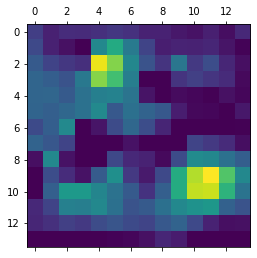

In [97]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [103]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('img/04_elephant_output.jpg', superimposed_img)

True

![output](img/04_elephant_output.jpg)

This visualization technique answers two important questions:
* Why did the network think this image contained an African elephant?
* Where is the African elephant located in the picture?